# Домашнее задание 2. StarGAN

## Этап 1. Установка зависимостей, инициализация и загрузка данных

В этом разделе мы работаем с датасетом CelebA, содержащим изображения лиц с набором атрибутов. Целью задания является генерация новых изображений лиц с заданными характеристиками.

In [1]:
import torch
from lpips import LPIPS
from torchvision import transforms
from munch import Munch
from tqdm.auto import trange
import matplotlib.pyplot as plt
import numpy as np
from celeba_loader import CelebADataset

device_str = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device(device_str)
print(f"Working with {device!r}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU device: {torch.cuda.get_device_name(0)}")

torch.cuda.empty_cache()
print(torch.cuda.memory_allocated() / 1024**2, "MB Allocated")
print(torch.cuda.memory_reserved() / 1024**2, "MB Reserved")

Working with device(type='cuda')
PyTorch version: 2.5.1+cu121
CUDA available: True
GPU device: Tesla V100-SXM2-32GB
0.0 MB Allocated
0.0 MB Reserved


In [2]:
args = Munch()
args.img_size = 256  # Размер изображений после преобразования

# Создание последовательности преобразований для подготовки изображений
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Загрузка датасета CelebA с применением указанных преобразований
from torch.utils.data import Subset
original_dataset = CelebADataset(
    root_dir='data/celeba',
    transform=transform)

dataset = Subset(original_dataset, list(range(10000)))
# Manually copy over the 'header' from the original dataset
dataset.header = original_dataset.header

# Число потоков для загрузки данных
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# !!!!!!!!!! Alarm alarm !!!!!!!!!!!!
num_workers = 0
pin_memory = False
# !!!!!!!!!! Alarm alarm !!!!!!!!!!!!

args.batch_size = 12

# Создание DataLoader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [3]:
args.num_domains = len(dataset.header)
print(args.num_domains)
print(dataset.header)

40
['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


### Визуализация датасета

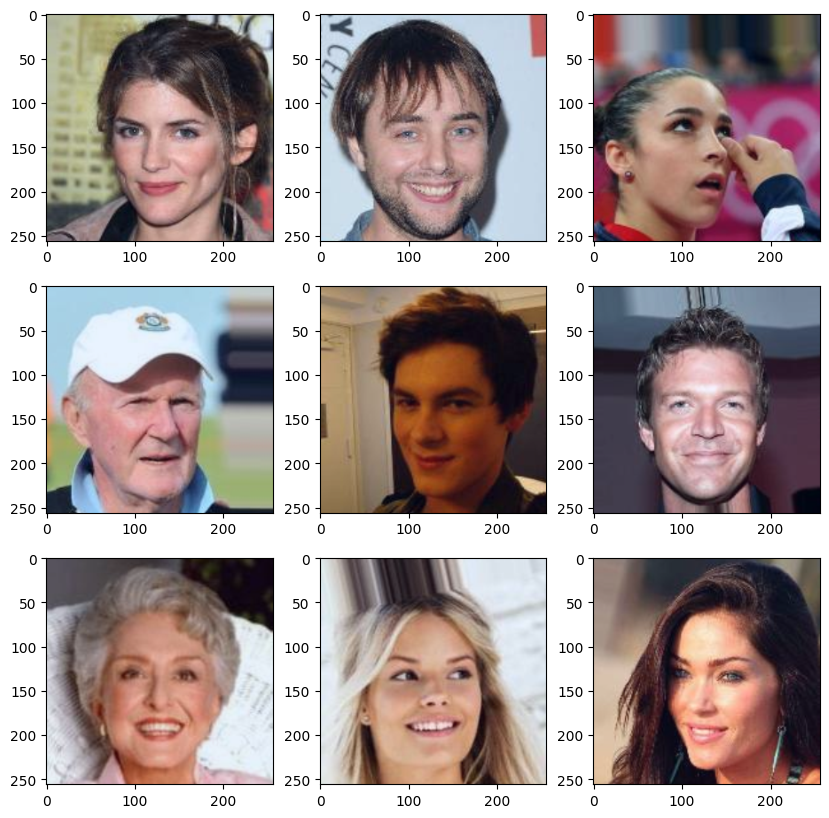

In [4]:
# Визуализация случайно выбранных изображений из датасета

_, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), 9)):

    img, target = dataset[img_idx]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i // 3][i % 3].imshow(img.detach().cpu().numpy().transpose(1, 2, 0))

## Этап 2. Инициализация и обучение модели

В этом этапе необходимо реализовать и обучить модель StarGAN для генерации лиц с заданными атрибутами.

Вы можете выбрать одну из следующих моделей:
- [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**)
- [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

### Инициализация

Ниже приведён шаблон для определения основных компонентов модели. Реализуйте их по своему усмотрению.

In [5]:
# Создание структуры для хранения компонентов модели
from starganv2.model import Generator, MappingNetwork, StyleEncoder, Discriminator
args.style_dim = 64
args.max_conv_dim = 512
args.disc_max_conv_dim = 512
args.latent_dim = 16

nets = Munch()
nets.generator = torch.nn.DataParallel(Generator(img_size=args.img_size, style_dim=args.style_dim, max_conv_dim=args.max_conv_dim).to(device))
nets.mapping_network = torch.nn.DataParallel(MappingNetwork(latent_dim=args.latent_dim, style_dim=args.style_dim, num_domains=args.num_domains).to(device))
nets.style_encoder = torch.nn.DataParallel(StyleEncoder(img_size=args.img_size, style_dim=args.style_dim, num_domains=args.num_domains, max_conv_dim = args.max_conv_dim).to(device))
nets.discriminator = torch.nn.DataParallel(Discriminator(img_size=args.img_size, num_domains=args.num_domains, max_conv_dim=args.disc_max_conv_dim).to(device))

# nets.generator = ...           # Генератор, отвечающий за преобразование изображений
# nets.mapping_network = ...     # Сеть маппинга: преобразует латентный вектор в стиль
# nets.style_encoder = ...       # Энкодер стиля: извлекает стиль из изображений
# nets.discriminator = ...       # Дискриминатор: оценивает реалистичность сгенерированных изображений

### Обучение

In [6]:
import torch
from torch.utils.data import Dataset
import random
from tqdm.auto import tqdm
import os
import torch

class AttributePairDataset(Dataset):
    def __init__(self, base_dataset, attribute_dim=40, indices_file="attr_indices.pt"):
        self.base_dataset = base_dataset

        # If we’ve already precomputed attr_to_indices before, just load it.
        #if os.path.exists(indices_file):
        #    print(f"Loading precomputed attr_to_indices from {indices_file}")
        #    self.attr_to_indices = torch.load(indices_file)
        #else:
        if True:
            # Otherwise, build it and then save it.
            self.attr_to_indices = {i: [] for i in range(attribute_dim)}
            for idx in tqdm(range(len(base_dataset))):
                _, metadata = base_dataset[idx]
                attributes = metadata['attributes']
                if isinstance(attributes, torch.Tensor):
                    attributes = attributes.tolist()
                for i, val in enumerate(attributes):
                    if val == 1:
                        self.attr_to_indices[i].append(idx)

            print(f"Saving attr_to_indices to {indices_file}")
            torch.save(self.attr_to_indices, indices_file)

        # Filter out attributes that don't have at least 2 samples
        self.valid_attrs = [i for i, inds in self.attr_to_indices.items() if len(inds) >= 2]
        if not self.valid_attrs:
            raise ValueError("No attribute has at least 2 samples.")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, index):
        y_trg = random.choice(self.valid_attrs)
        indices = self.attr_to_indices[y_trg]
        i1, i2 = random.sample(indices, 2)
        x_ref, _ = self.base_dataset[i1]
        x_ref2, _ = self.base_dataset[i2]
        return x_ref, x_ref2, y_trg


ref_dataset = AttributePairDataset(dataset)


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving attr_to_indices to attr_indices.pt


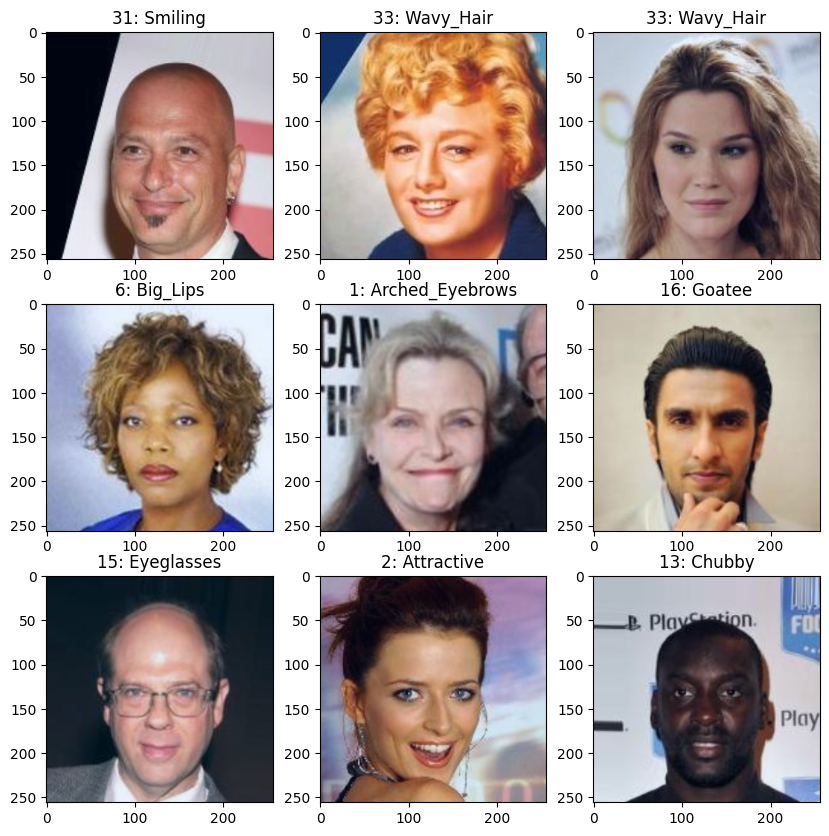

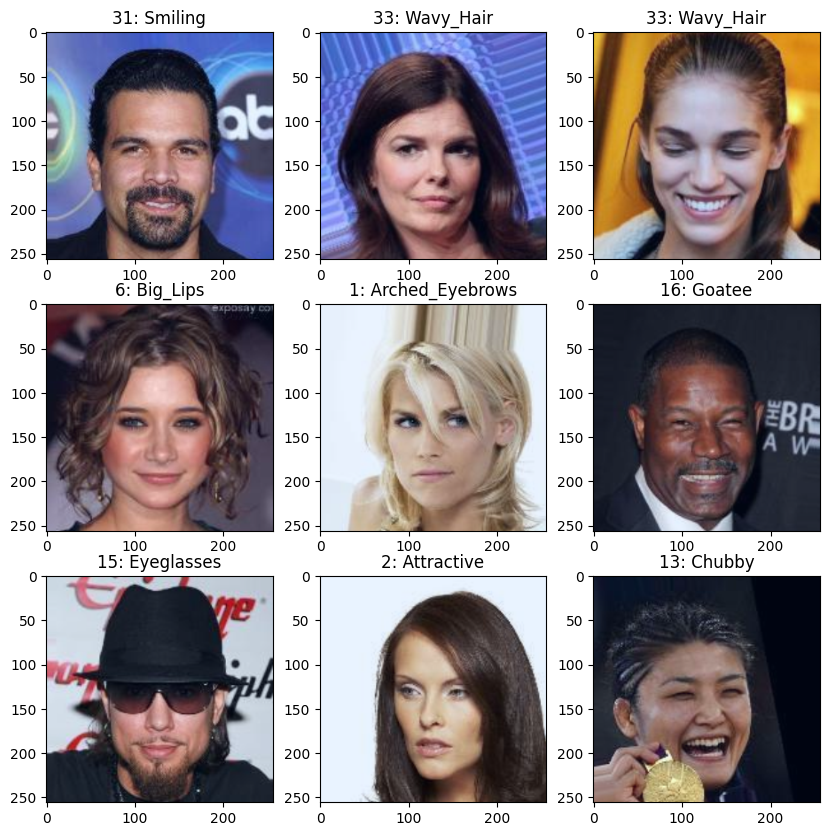

In [7]:
_, axes = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
_, axes2 = plt.subplots(ncols=3, nrows=3, figsize=(10, 10))
for i, img_idx in enumerate(np.random.choice(range(len(ref_dataset)), 9)):

    x_ref, x_ref2, y_trg = ref_dataset[img_idx]
    x_ref = (x_ref - x_ref.min()) / (x_ref.max() - x_ref.min())
    x_ref2 = (x_ref2 - x_ref2.min()) / (x_ref2.max() - x_ref2.min())
    axes[i // 3][i % 3].imshow(x_ref.detach().cpu().numpy().transpose(1, 2, 0))
    axes[i // 3][i % 3].set_title(f"{y_trg}: {dataset.header[y_trg]}")
    axes2[i // 3][i % 3].imshow(x_ref2.detach().cpu().numpy().transpose(1, 2, 0))
    axes2[i // 3][i % 3].set_title(f"{y_trg}: {dataset.header[y_trg]}")

In [8]:
ref_dataloader = torch.utils.data.DataLoader(
    ref_dataset,
    batch_size=args.batch_size,
    num_workers=num_workers,
    pin_memory=pin_memory,
    shuffle=True
)

In [ ]:
import torch.nn.functional as F
from tqdm.auto import trange, tqdm
import numpy as np

args.sample_dir = "samples"

optims = Munch()
optims.generator = torch.optim.Adam(nets.generator.parameters(), lr=0.0001)
optims.mapping_network = torch.optim.Adam(nets.mapping_network.parameters(), lr=0.0001)
optims.style_encoder = torch.optim.Adam(nets.style_encoder.parameters(), lr=0.0001)
optims.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=0.0001, betas=(0.0, 0.99))

# Use training mode
nets.generator.train()
nets.mapping_network.train()
nets.style_encoder.train()
nets.discriminator.train()

import torch
import torch.nn.functional as F

def compute_d_loss(x_real, y_org, y_trg, z_trg=None, x_ref=None):
    out_real = nets.discriminator(x_real, y_org)
    d_real_loss = F.relu(1 - out_real).mean()

    # Fake images:
    with torch.no_grad():
        if x_ref is not None:
            # Reference-guided style
            s_trg = nets.style_encoder(x_ref, y_trg)
        else:
            # Latent-guided style
            s_trg = nets.mapping_network(z_trg, y_trg)
        x_fake = nets.generator(x_real, s_trg)

    out_fake = nets.discriminator(x_fake, y_trg)
    d_fake_loss = F.relu(1 + out_fake).mean()

    d_loss = d_real_loss + d_fake_loss
    return d_loss

def compute_g_loss(
    x_real, y_org, y_trg,
    z_trgs=None, x_refs=None,
    lambda_sty=1.0,     # weight for style reconstruction loss
    lambda_ds=1.0,      # weight for style diversification loss
):
    if x_refs is not None:
        # Reference-guided
        s_trg_list = [nets.style_encoder(x_ref, y_trg) for x_ref in x_refs]
    else:
        # Latent-guided
        s_trg_list = [nets.mapping_network(z_trg, y_trg) for z_trg in z_trgs]

    # -----------------------------------------------------------------------
    # 1. Adversarial loss: make D(x_fake, y_trg) be "real".
    #    We generate x_fake for each style code.
    # -----------------------------------------------------------------------
    x_fake_list = []
    adv_loss = 0.
    for s_trg in s_trg_list:
        x_fake = nets.generator(x_real, s_trg)
        x_fake_list.append(x_fake)
        out_fake = nets.discriminator(x_fake, y_trg)
        adv_loss += -out_fake.mean()

    adv_loss = adv_loss / len(s_trg_list)   # average over the multiple styles

    # -----------------------------------------------------------------------
    # 2. Style reconstruction loss:
    #    If we used a reference style s_trg, or we used a mapping-network style s_trg,
    #    we can re-encode the generated image x_fake to see if we recover the same style.
    # -----------------------------------------------------------------------
    sty_loss = 0.
    for s_trg, x_fake in zip(s_trg_list, x_fake_list):
        s_pred = nets.style_encoder(x_fake, y_trg)   # re-encode the generated image
        sty_loss += F.l1_loss(s_pred, s_trg)
    sty_loss = sty_loss / len(s_trg_list)

    # -----------------------------------------------------------------------
    # 3. Style diversification loss (DS loss):
    #    Encourage x_fake to differ if s_trg differs. The official code does:
    #        L1 distance between x_fake1 and x_fake2 in feature-space or pixel-space,
    #        with a negative sign so that G tries to maximize difference.
    #    Usually done with an additional encoder or feature extractor. We'll do a
    #    simple pixel-level approach here for demonstration.
    # -----------------------------------------------------------------------
    ds_loss = 0.
    if len(s_trg_list) == 2:
        # Suppose we have 2 different styles in s_trg_list => x_fake1, x_fake2
        x_fake1, x_fake2 = x_fake_list
        # A simple example is the negative L1 distance => we want them to differ:
        ds_loss = -F.l1_loss(x_fake1, x_fake2)
        # The official StarGAN v2 code does “ds_loss = -||E(x_fake1)-E(x_fake2)||1”
        # or a similar approach in a latent/feature space. But pixel-level can be used
        # as an illustrative example.

    # -----------------------------------------------------------------------
    # 4. Combine losses
    # -----------------------------------------------------------------------
    g_loss = adv_loss + lambda_sty * sty_loss + lambda_ds * ds_loss
    return g_loss

import torchvision
import torchvision.utils as vutils

@torch.no_grad()
def translate_and_reconstruct(nets, args, x_src, y_src, x_ref, y_ref, filename):
    N, C, H, W = x_src.size()
    s_ref = nets.style_encoder(x_ref, y_ref)
    x_fake = nets.generator(x_src, s_ref)
    s_src = nets.style_encoder(x_src, y_src)
    x_rec = nets.generator(x_fake, s_src)
    x_concat = [x_src, x_ref, x_fake, x_rec]
    x_concat = torch.cat(x_concat, dim=0)
    vutils.save_image(x_concat.cpu(), filename, nrow=N, padding=0)
    del x_concat

@torch.no_grad()
def translate_using_latent(nets, args, x_src, y_trg_list, z_trg_list, psi, filename):
    N, C, H, W = x_src.size()
    latent_dim = z_trg_list[0].size(1)
    x_concat = [x_src]

    for i, y_trg in enumerate(y_trg_list):
        z_many = torch.randn(10000, latent_dim).to(x_src.device)
        y_many = torch.LongTensor(10000).to(x_src.device).fill_(y_trg[0])
        s_many = nets.mapping_network(z_many, y_many)
        s_avg = torch.mean(s_many, dim=0, keepdim=True)
        s_avg = s_avg.repeat(N, 1)

        for z_trg in z_trg_list:
            s_trg = nets.mapping_network(z_trg, y_trg)
            s_trg = torch.lerp(s_avg, s_trg, psi)
            x_fake = nets.generator(x_src, s_trg)
            x_concat += [x_fake]

    x_concat = torch.cat(x_concat, dim=0)
    vutils.save_image(x_concat.cpu(), filename, nrow=N, padding=0)
    del x_concat


@torch.no_grad()
def translate_using_reference(nets, args, x_src, x_ref, y_ref, filename):
    N, C, H, W = x_src.size()
    wb = torch.ones(1, C, H, W).to(x_src.device)
    x_src_with_wb = torch.cat([wb, x_src], dim=0)

    s_ref = nets.style_encoder(x_ref, y_ref)
    s_ref_list = s_ref.unsqueeze(1).repeat(1, N, 1)
    x_concat = [x_src_with_wb]
    for i, s_ref in enumerate(s_ref_list):
        x_fake = nets.generator(x_src, s_ref)
        x_fake_with_ref = torch.cat([x_ref[i:i+1], x_fake], dim=0)
        x_concat += [x_fake_with_ref]

    x_concat = torch.cat(x_concat, dim=0)
    vutils.save_image(x_concat.cpu(), filename, nrow=N, padding=0)
    del x_concat



weights = torch.load('weights/1v100__10000iters_10000photos_try2.pth')
nets.generator.load_state_dict(weights['generator_state_dict'])
nets.mapping_network.load_state_dict(weights['mapping_network_state_dict'])
nets.style_encoder.load_state_dict(weights['style_encoder_state_dict'])
nets.discriminator.load_state_dict(weights['discriminator_state_dict'])
optims.generator.load_state_dict(weights['optim_generator_state_dict'])
optims.mapping_network.load_state_dict(weights['optim_mapping_network_state_dict'])
optims.style_encoder.load_state_dict(weights['optim_style_encoder_state_dict'])
optims.discriminator.load_state_dict(weights['optim_discriminator_state_dict'])


num_iterations = 10000
for idx in tqdm(range(num_iterations), desc="Training iterations", leave=False):
    x_real, real_metadata = next(iter(dataloader))
    x_real = x_real.to(device)
    y_org = real_metadata['attributes'].to(device).argmax(dim=1)

    x_ref, x_ref2, y_trg = next(iter(ref_dataloader))
    x_ref = x_ref.to(device)
    x_ref2 = x_ref2.to(device)
    z_trg, z_trg2 = torch.randn(args.batch_size, args.latent_dim, device=device), torch.randn(args.batch_size, args.latent_dim, device=device)

    # Train discriminator
    d_loss = compute_d_loss(x_real, y_org, y_trg, z_trg=z_trg)
    optims.discriminator.zero_grad()
    d_loss.backward()
    optims.discriminator.step()

    d_loss = compute_d_loss(x_real, y_org, y_trg, x_ref=x_ref)
    optims.discriminator.zero_grad()
    d_loss.backward()
    optims.discriminator.step()

    # Train generator
    g_loss = compute_g_loss(x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2])
    optims.generator.zero_grad()
    optims.mapping_network.zero_grad()
    optims.style_encoder.zero_grad()
    g_loss.backward()
    optims.generator.step()
    optims.mapping_network.step()
    optims.style_encoder.step()

    g_loss = compute_g_loss(x_real, y_org, y_trg, x_refs=[x_ref, x_ref2])
    optims.generator.zero_grad()
    g_loss.backward()
    optims.generator.step()

    if idx % 500 == 0:
        with torch.no_grad():
            # translate and reconstruct (reference-guided)

            filename = args.sample_dir + f'/{idx}_cycle_consistency.jpg'
            translate_and_reconstruct(nets, args, x_real, y_org, x_ref, y_trg, filename)
            # latent-guided image synthesis
            y_trg_list = [torch.tensor(y).repeat(args.batch_size).to(device)
                        for y in range(min(args.num_domains, 5))]
            z_trg_list = torch.randn(2, 1, args.latent_dim).repeat(1, args.batch_size, 1).to(device)
            for psi in [0.5, 0.7, 1.0]:
                filename = args.sample_dir + f'/{idx}_latent_psi_{psi}.jpg'
                translate_using_latent(nets, args, x_real, y_trg_list, z_trg_list, psi, filename)

            # reference-guided image synthesis
            filename = args.sample_dir + f'/{idx}_reference.jpg'
            translate_using_reference(nets, args, x_real, x_ref, y_trg, filename)



/tmp/ipykernel_4002/1825897906.py:167: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load('weights/1v100__10000iters_10000photos_try2.pth')


Training iterations:   0%|          | 0/10000 [00:00<?, ?it/s]

In [34]:
weights = {
    'generator_state_dict': nets.generator.state_dict(),
    'mapping_network_state_dict': nets.mapping_network.state_dict(),
    'style_encoder_state_dict': nets.style_encoder.state_dict(),
    'discriminator_state_dict': nets.discriminator.state_dict(),
    'optim_generator_state_dict': optims.generator.state_dict(),
    'optim_mapping_network_state_dict': optims.mapping_network.state_dict(),
    'optim_style_encoder_state_dict': optims.style_encoder.state_dict(),
    'optim_discriminator_state_dict': optims.discriminator.state_dict(),
    'args': args,
}
torch.save(weights, "weights/1v100__10000iters_10000photos_try3.pth")

### Оценка модели

Для оценки качества сгенерированных изображений используется метрика LPIPS.

In [ ]:
lpips = LPIPS()

In [ ]:
test_iters = 100  # Количество итераций для тестирования модели
values = []

nets.generator.eval()
nets.style_encoder.eval()

for i in trange(test_iters):
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))

    batch_size = x_real.shape[0]

    # Случайное задание целевого и исходного доменов для каждого изображения
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен

    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]

    # Генерация изображения с использованием вашей модели
    s_ref = nets.style_encoder(x_ref, y_trg)
    x_fake = nets.generator(x_real, s_ref)

    # Вычисление LPIPS между сгенерированным и реальным изображением
    lpips_vals = lpips(x_fake.cpu(), x_real.cpu()).squeeze()
    values.extend(lpips_vals.tolist())

print("Среднее значение LPIPS:", np.mean(values))
assert np.mean(values) < 1.3

### Вывод результатов оценки

(np.float64(-0.5), np.float64(1535.5), np.float64(511.5), np.float64(-0.5))

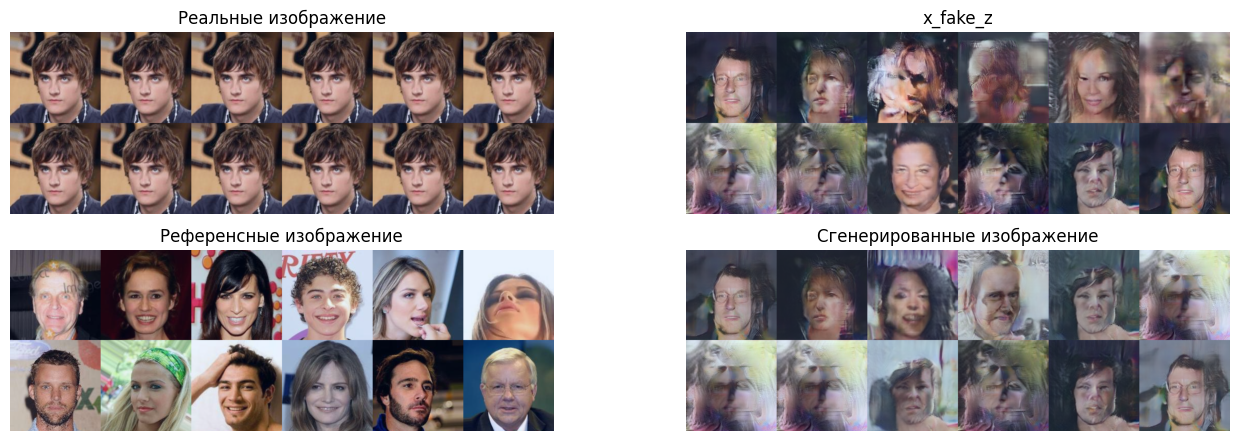

In [35]:
from torchvision.utils import make_grid
nets.generator.eval()
nets.mapping_network.eval()
nets.style_encoder.eval()
nets.discriminator.eval()
with torch.no_grad():
    x_real, _ = next(iter(dataloader))
    x_real = x_real[0].unsqueeze(0).repeat(x_real.size(0), 1, 1, 1)
    x_ref, x_ref2, y_trg = next(iter(ref_dataloader))

    batch_size = x_real.shape[0]

    # Случайное задание целевого и исходного доменов для каждого изображения
    #y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Целевой домен
    #y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size))  # Исходный домен

    # Перенос данных на выбранное устройство и приведение типов
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]

    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
    x_fake_z = nets.generator(x_real, s_trg)

    s_trg = nets.style_encoder(x_ref, y_trg)
    x_fake = nets.generator(x_real, s_trg)

plt.figure(figsize=(16, 8))

plt.subplot(3, 2, 1)
plt.imshow(make_grid(x_real, nrow=6, padding=0, normalize=True).permute(1, 2, 0).detach().cpu().numpy())
plt.title("Реальные изображение")
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(make_grid(x_fake_z, nrow=6, padding=0, normalize=True).permute(1, 2, 0).detach().cpu().numpy())
plt.title("x_fake_z")
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(make_grid(x_ref, nrow=6, padding=0, normalize=True).permute(1, 2, 0).detach().cpu().numpy())
plt.title("Референсные изображение")
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(make_grid(x_fake, nrow=6, padding=0, normalize=True).permute(1, 2, 0).detach().cpu().numpy())
plt.title("Сгенерированные изображение")
plt.axis('off')

## Этап 3. Дополнительный анализ

В данном разделе рекомендуется провести дополнительные эксперименты и анализ:
- **Анализ латентного пространства**. *(2 балла)*
- **Текстовое ревью решения**: опишите, какие изменения можно внести для улучшения модели, и обоснуйте их. *(1 балл)*

Как-то очень трудно обучать starganV2, что-то получилось нагенерировать, но качество расcтраивает конечно.

Думаю надо было использовать предобученную модель как это делали авторы для вычленения наиболее значимых частей изображений

\+

Наша задача по ресурсам кажется была кратно сложнее, у авторов было только 2 домена мужчина и женщина

Если бы было больше времени, думаю с использованием предобученных моделей получилось бы хорошо обучить

Поэтому дальше см. ноутбук для StarGANv1